In [9]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [10]:
import glob
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import *
from models.gan import ResNetDiscriminator, StyleVectorizer
from data_funcs import *
from utils.logger import Logger
import utils.gan_utils as gan_utils

In [11]:
RUN_CELEBA = "../outputs/id=padpaf-celeba*/task=celeba-fedgan/*/seed=123/model/*"
RUN_CELEBA_2D5 = "../outputs/id=padpaf-celeba*2D5/task=celeba-fedgan/*/seed=123/model/*"
RUN_CELEBA_2D5_CONT = "../outputs/id=padpaf-celeba*2D5-cont/task=celeba-fedgan/*/seed=123/model/*"

RUN_CELEBA = "/home/abdulla.almansoori/projects/PaDPaF/outputs/id=padpaf/task=celeba-fedgan/lr=0.001_0.01/seed=123/model/*"

MODEL_PATHS = RUN_CELEBA

In [12]:
conditional = 'conditional' in MODEL_PATHS
unseen = 'unseen' in MODEL_PATHS

In [13]:
# model_paths = glob.glob("models/partial/normal/model_round*.pth.tar")
def get_round(model_path):
    return int(model_path[-11:-8])

model_paths = glob.glob(MODEL_PATHS)
# model_paths = sorted(model_paths, key=lambda pth: get_round(pth))  # sort by round
for p in model_paths: print(p)

/home/abdulla.almansoori/projects/PaDPaF/outputs/id=padpaf/task=celeba-fedgan/lr=0.001_0.01/seed=123/model/model.pth.tar


## Init setting and model

In [14]:
classifier_is_linear = True  # else: 2-layer nn with relu

Logger.setup_logging("INFO", logfile="")
Logger()

image_size = 64
channels = 3
seed = 123
dataset_name = "celeba"
data_path = "../data/"
num_workers = 0
batch_size = 32
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_attr = 40
num_identities = 10177 + 1

batch_size = 256
lr = 1e-1
epochs = 50
lr_gamma = 0.95

In [15]:
loader_kwargs = {}
if not device == 'cpu':
    loader_kwargs["num_workers"] = num_workers
    loader_kwargs["persistent_workers"] = num_workers > 0

In [16]:
_, test_dataset = load_data(dataset=dataset_name, path=data_path, image_size=image_size, target_type='identity')

0it [00:00, ?it/s]

/home/abdulla.almansoori/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/utils.py:272: UserWarning: We detected some HTML elements in the downloaded file. This most likely means that the download triggered an unhandled API response by GDrive. Please report this to torchvision at https://github.com/pytorch/vision/issues including the response:

<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="N8zzfdsS0-WGr6gEK4rbDw">.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial,sans-serif;margin:0}.grecaptcha-badge{visibility:hidden}.uc-main{padding-top:50px;text-align:center}#uc-dl-icon{display:inline-block;margin-top:16px;padding-right:1em;vertical-align:top}#uc-text{display:inline-block;max-width:68ex;text-align:lef

RuntimeError: The MD5 checksum of the download file ../data/celeba/img_align_celeba.zip does not match the one on record.Please delete the file and try again. If the issue persists, please report this to torchvision at https://github.com/pytorch/vision/issues.

## Load test dataset

In [9]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **loader_kwargs)
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5+0.5*x))))
    for i in range(0, y.size(0), 8):
        print([iden.item() for iden in y[i:i+8]])
    break

NameError: name 'test_dataset' is not defined

## Load model

In [10]:
def init_styleD(num_features=128):
     return ResNetDiscriminator(num_features=num_features, image_size=image_size, channels=channels)


def init_style_map(num_latents=256):
     return StyleVectorizer(num_latents, 8, lr_mul=0.1)

    
def init_model(num_latents=256, num_features=128):
    return FedGAN(num_latents=num_latents,
                             D_features=num_features, G_features=num_features,
                             image_size=image_size, channels=channels, num_classes=num_attr if conditional else 0, embed_class=False)

global_model = init_model().to(device)

In [22]:
def moving_avg(series, t=1):
    return series
    ###
    avgs = []
    for i in range(1, len(series) + 1):
        last_t = series[:i][-t:]
        avg = sum(last_t) / len(last_t)
        avgs.append(avg)
    return avgs


def load_fedgan_one_style(global_model, fp, style_id=0, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'])
    # Local modules
    local_state_dict = state_dict[str(style_id)]
    global_model.styleD.load_state_dict(local_state_dict['styleD'])
    global_model.style_map.load_state_dict(local_state_dict['style_map'])
    return global_model


def load_fedgan_all_styles(global_model, fp, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'])
    private_modules = []
    for worker_id in range(len(state_dict)):
        if str(worker_id) not in state_dict:
            continue
        # Local modules
        local_state_dict = state_dict[str(worker_id)]
        # TODO: can't we just deepcopy from global_model? (write copy() method)
        styleD = init_styleD().to(device)
        styleD.load_state_dict(local_state_dict['styleD'])
        style_map = init_style_map().to(device)
        style_map.load_state_dict(local_state_dict['style_map'])
        style_modules = {
            "id": worker_id,
            "styleD": styleD,
            "style_map": style_map,
        }
        private_modules.append(style_modules)
    return global_model, private_modules

## Train a linear classifier on content features and a one style features

In [23]:
classifier_name = 'linear_classifier' if classifier_is_linear else 'mlp_classifier'

def make_classifier(num_features, output_dim=num_identities, linear=classifier_is_linear):
    if linear:
        return nn.Linear(num_features, output_dim)
    else:
        return nn.Sequential(
            nn.Linear(num_features, num_features),
            nn.BatchNorm1d(num_features),
            nn.ReLU(),
            nn.Linear(num_features, output_dim),
        )

classifier_name

'linear_classifier'

In [24]:
global_model = load_fedgan_one_style(global_model, model_paths[-1], style_id=0, device=device)

In [25]:
content_classifier = make_classifier(global_model.contentD.hidden_dim).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

style_classifier = make_classifier(global_model.styleD.hidden_dim).to(device)
style_classifier_optim = torch.optim.Adam(style_classifier.parameters(), lr=lr)
style_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(style_classifier_optim, gamma=lr_gamma)

loss_fn = nn.CrossEntropyLoss().to(device)

print(sum(p.numel() for p in content_classifier.parameters()))

5221314


In [ ]:
content_losses = []
content_accs = []
content_accs_10 = []
content_accs_50 = []
style_losses = []
style_accs = []
style_accs_10 = []
style_accs_50 = []
for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    mean_content_acc_10 = 0.0
    mean_content_acc_50 = 0.0
    mean_style_loss = 0.0
    mean_style_acc = 0.0
    mean_style_acc_10 = 0.0
    mean_style_acc_50 = 0.0
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            _, style_features = global_model.styleD(x, return_h=True)
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        content_y_10 = content_pred.topk(10, dim=1).indices
        content_y_50 = content_pred.topk(50, dim=1).indices
        style_pred = style_classifier(style_features)
        style_y = style_pred.max(dim=1).indices
        style_y_10 = style_pred.topk(10, dim=1).indices
        style_y_50 = style_pred.topk(50, dim=1).indices
        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        style_loss = loss_fn(style_pred, y)
        content_classifier_optim.zero_grad()
        style_classifier_optim.zero_grad()
        content_loss.backward()
        style_loss.backward()
        content_classifier_optim.step()
        style_classifier_optim.step()
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        content_acc_10 = (content_y_10 == y.view(-1,1).repeat(1,10)).any(dim=1).sum() / y.size(0)
        content_acc_50 = (content_y_50 == y.view(-1,1).repeat(1,50)).any(dim=1).sum() / y.size(0)
        style_acc = (style_y == y).sum() / y.size(0)
        style_acc_10 = (style_y_10 == y.view(-1,1).repeat(1,10)).any(dim=1).sum() / y.size(0)
        style_acc_50 = (style_y_50 == y.view(-1,1).repeat(1,50)).any(dim=1).sum() / y.size(0)
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        mean_content_acc_10 += content_acc_10.item() / len(test_loader)
        mean_content_acc_50 += content_acc_50.item() / len(test_loader)
        mean_style_loss += style_loss.item() / len(test_loader)
        mean_style_acc += style_acc.item() / len(test_loader)
        mean_style_acc_10 += style_acc_10.item() / len(test_loader)
        mean_style_acc_50 += style_acc_50.item() / len(test_loader)
        if i % (len(test_loader) // 10) == 0:
            correction = len(test_loader) / (i+1)
            print(f"[{epoch+1}/{epochs}][{i+1}/{len(test_loader)}] "
                  f"content_loss = {mean_content_loss*correction:4f}\t"
                  f"content_acc = {mean_content_acc*correction:4f}\t"
                  f"content_acc_10 = {mean_content_acc_10*correction:4f}\t"
                  f"content_acc_50 = {mean_content_acc_50*correction:4f}\t"
                  f"style_loss = {mean_style_loss*correction:4f}\t"
                  f"style_acc = {mean_style_acc*correction:4f}\t"
                  f"style_acc_10 = {mean_style_acc_10*correction:4f}\t"
                  f"style_acc_50 = {mean_style_acc_50*correction:4f}"
            )
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    content_accs_10.append(mean_content_acc_10)
    content_accs_50.append(mean_content_acc_50)
    style_losses.append(mean_style_loss)
    style_accs.append(mean_style_acc)
    style_accs_10.append(mean_style_acc_10)
    style_accs_50.append(mean_style_acc_50)
    print(f"[{epoch+1}/{epochs}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          f"content_acc_10 = {mean_content_acc_10:4f}\t"
          f"content_acc_50 = {mean_content_acc_50:4f}\t"
          f"style_loss = {mean_style_loss:4f}\t"
          f"style_acc = {mean_style_acc:4f}\t"
          f"style_acc_10 = {mean_style_acc_10:4f}\t"
          f"style_acc_50 = {mean_style_acc_50:4f}"
    )
    content_classifier_optim_sched.step()
    style_classifier_optim_sched.step()

[1/50][1/636] content_loss = 9.256179	content_acc = 0.000000	content_acc_10 = 0.000000	content_acc_50 = 0.003906	style_loss = 9.226106	style_acc = 0.000000	style_acc_10 = 0.003906	style_acc_50 = 0.007812
[1/50][64/636] content_loss = 14.536020	content_acc = 0.000305	content_acc_10 = 0.002441	content_acc_50 = 0.012268	style_loss = 11.454146	style_acc = 0.000549	style_acc_10 = 0.003418	style_acc_50 = 0.011658
[1/50][127/636] content_loss = 13.803983	content_acc = 0.000554	content_acc_10 = 0.004583	content_acc_50 = 0.016548	style_loss = 10.978277	style_acc = 0.000953	style_acc_10 = 0.005690	style_acc_50 = 0.018301
[1/50][190/636] content_loss = 13.555887	content_acc = 0.001069	content_acc_10 = 0.006312	content_acc_50 = 0.021793	style_loss = 10.788096	style_acc = 0.001254	style_acc_10 = 0.007340	style_acc_50 = 0.023623
[1/50][253/636] content_loss = 13.390570	content_acc = 0.001698	content_acc_10 = 0.008832	content_acc_50 = 0.027236	style_loss = 10.660392	style_acc = 0.001868	style_acc_10 

In [ ]:
plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_losses)), label="style", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(f"results/celeba_{classifier_name}{'_cond' if conditional else ''}_loss_one_style0.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content, top 1", color='C0', linestyle='solid')
plt.plot(np.array(moving_avg(content_accs_10)), label="content, top 10", color='C2', linestyle='solid')
plt.plot(np.array(moving_avg(content_accs_50)), label="content, top 50", color='C4', linestyle='solid')
plt.plot(np.array(moving_avg(style_accs)), label="style, top 1", color='C1', linestyle='dashed')
plt.plot(np.array(moving_avg(style_accs_10)), label="style, top 10", color='C3', linestyle='dashed')
plt.plot(np.array(moving_avg(style_accs_50)), label="style, top 50", color='C5', linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(prop={'size': 8})
plt.tight_layout()
plt.savefig(f"results/celeba_{classifier_name}{'_cond' if conditional else ''}_acc_one_style0.pdf")

## Train a classifier on all style features

In [25]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)
[m["id"] for m in private_modules]

[0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
content_classifier = make_classifier(global_model.contentD.num_features).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

for m in private_modules:
    m["classifier"] = make_classifier(global_model.styleD.num_features).to(device)
    m["classifier_optim"] = torch.optim.Adam(m["classifier"].parameters(), lr=lr)
    m["classifier_optim_sched"] = torch.optim.lr_scheduler.ExponentialLR(m["classifier_optim"], gamma=lr_gamma)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
content_losses = []
content_accs = []
for m in private_modules:
    m["losses"] = []
    m["accs"] = []

for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    for m in private_modules:
        m["mean_loss"] = 0.0
        m["mean_acc"] = 0.0

    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            all_style_features = [m["styleD"](x, return_h=True)[1] for m in private_modules]
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        all_style_pred = [m["classifier"](f) for m, f in zip(private_modules, all_style_features)]
        all_style_y = [pred.max(dim=1).indices for pred in all_style_pred]
        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        all_style_loss = [loss_fn(pred, y) for pred in all_style_pred]
        content_classifier_optim.zero_grad()
        [m["classifier_optim"].zero_grad() for m in private_modules]
        content_loss.backward()
        [loss.backward() for loss in all_style_loss]
        content_classifier_optim.step()
        [m["classifier_optim"].step() for m in private_modules]
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        all_style_acc = [(style_y == y).sum() / y.size(0) for style_y in all_style_y]
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        for m, loss, acc in zip(private_modules, all_style_loss, all_style_acc):
            m["mean_loss"] += loss.item() / len(test_loader)
            m["mean_acc"] += acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    for m in private_modules:
        m["losses"].append(m["mean_loss"])
        m["accs"].append(m["mean_acc"])
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          + "\t".join(
              f"style[{m['id']}]_loss = {m['mean_loss']:4f}\t"
              f"style[{m['id']}]_acc = {m['mean_acc']:4f}"
              for m in private_modules
          )
         )
    content_classifier_optim_sched.step()
    [m["classifier_optim_sched"].step() for m in private_modules]

[1/50] content_loss = 0.837149	content_acc = 0.810304	style[0]_loss = 2.242249	style[0]_acc = 0.167432	style[1]_loss = 2.290345	style[1]_acc = 0.137181	style[2]_loss = 2.277318	style[2]_acc = 0.148163	style[3]_loss = 2.225122	style[3]_acc = 0.211562	style[4]_loss = 2.226882	style[4]_acc = 0.204872	style[5]_loss = 2.191709	style[5]_acc = 0.197484	style[6]_loss = 2.153227	style[6]_acc = 0.207967	style[7]_loss = 2.237788	style[7]_acc = 0.187700
[2/50] content_loss = 0.284644	content_acc = 0.937200	style[0]_loss = 2.198197	style[0]_acc = 0.200879	style[1]_loss = 2.250599	style[1]_acc = 0.179413	style[2]_loss = 2.224299	style[2]_acc = 0.192692	style[3]_loss = 2.090625	style[3]_acc = 0.287640	style[4]_loss = 2.156717	style[4]_acc = 0.252496	style[5]_loss = 2.112485	style[5]_acc = 0.247604	style[6]_loss = 2.073969	style[6]_acc = 0.244708	style[7]_loss = 2.153526	style[7]_acc = 0.240216
[3/50] content_loss = 0.209404	content_acc = 0.948982	style[0]_loss = 2.169133	style[0]_acc = 0.225539	style

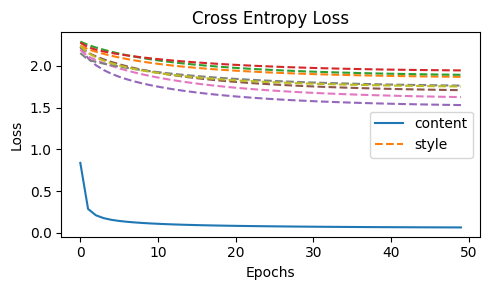

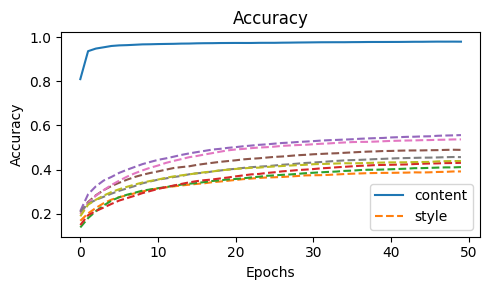

In [28]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', linestyle='solid',  label='content'),
                   Line2D([0], [0], color='C1', linestyle='dashed', label='style')]

plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
for m in private_modules:
    plt.plot(np.array(moving_avg(m["losses"])), label=f"style{m['id']}", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(handles=legend_elements)
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_all_styles.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content", linestyle='solid')
for m in private_modules:
    plt.plot(np.array(moving_avg(m["accs"])), label=f"style{m['id']}", linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(handles=legend_elements)
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_all_styles.pdf")

## Predict style

In [35]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)

In [36]:
content_classifier = make_classifier(global_model.contentD.num_features, output_dim=len(private_modules)).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

for m in private_modules:
    m["classifier"] = make_classifier(global_model.styleD.num_features, output_dim=1).to(device)
    m["classifier_optim"] = torch.optim.Adam(m["classifier"].parameters(), lr=lr)
    m["classifier_optim_sched"] = torch.optim.lr_scheduler.ExponentialLR(m["classifier_optim"], gamma=lr_gamma)

style_linear = make_classifier(len(private_modules), output_dim=len(private_modules)).to(device)
style_linear_optim = torch.optim.Adam(style_linear.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss().to(device)

print(sum(p.numel() for p in content_classifier.parameters()))

520


In [37]:
content_losses = []
content_accs = []
style_losses = []
style_accs = []

for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    mean_style_loss = 0.0
    mean_style_acc = 0.0

    for i, (x, y) in enumerate(test_loader):

        y = torch.randint(0, len(private_modules), (batch_size,)).to(device)  # y is the client now
        x_list = []
        for i in y:
            global_latent = torch.randn(1, global_model.num_latents).to(device)
            style_latent = torch.randn(1, global_model.num_latents).to(device)
            style = private_modules[i]["style_map"](style_latent)
            # label = torch.randint(0, num_attr, (1,)).to(device).int() if conditional else None
            xi = global_model.G(global_latent, cond=style, label=label)
            x_list.append(xi)
        x = torch.cat(x_list, dim=0)

        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            all_style_features = [m["styleD"](x, return_h=True)[1] for m in private_modules]
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        # stack predictions, get maximum out of all stacks per entry, then get maximum entry (i.e. get max probability)
        style_pred = torch.stack([m["classifier"](f) for m, f in zip(private_modules, all_style_features)], dim=1).squeeze()
        style_pred = style_linear(style_pred)
        style_y = style_pred.max(dim=1).indices

        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        style_loss = loss_fn(style_pred, y)
        content_classifier_optim.zero_grad()
        style_linear_optim.zero_grad()
        [m["classifier_optim"].zero_grad() for m in private_modules]
        content_loss.backward()
        style_loss.backward()
        content_classifier_optim.step()
        style_linear_optim.step()
        [m["classifier_optim"].step() for m in private_modules]
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        style_acc = (style_y == y).sum() / y.size(0)
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        mean_style_loss += style_loss.item() / len(test_loader)
        mean_style_acc += style_acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    style_losses.append(mean_style_loss)
    style_accs.append(mean_style_acc)
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          f"style_loss = {mean_style_loss:4f}\t"
          f"style_acc = {mean_style_acc:4f}\t"
         )
    content_classifier_optim_sched.step()
    [m["classifier_optim_sched"].step() for m in private_modules]

[1/50] content_loss = 1.317177	content_acc = 0.521765	style_loss = 0.808620	style_acc = 0.709964	
[2/50] content_loss = 0.920167	content_acc = 0.654153	style_loss = 0.492766	style_acc = 0.805511	
[3/50] content_loss = 0.800729	content_acc = 0.703275	style_loss = 0.453636	style_acc = 0.821785	
[4/50] content_loss = 0.736356	content_acc = 0.728934	style_loss = 0.422108	style_acc = 0.832768	
[5/50] content_loss = 0.702946	content_acc = 0.735024	style_loss = 0.409865	style_acc = 0.837560	
[6/50] content_loss = 0.663823	content_acc = 0.753095	style_loss = 0.369488	style_acc = 0.857228	
[7/50] content_loss = 0.626783	content_acc = 0.765675	style_loss = 0.346619	style_acc = 0.862320	
[8/50] content_loss = 0.618130	content_acc = 0.767372	style_loss = 0.345472	style_acc = 0.867712	
[9/50] content_loss = 0.602658	content_acc = 0.776458	style_loss = 0.328172	style_acc = 0.873702	
[10/50] content_loss = 0.600350	content_acc = 0.774261	style_loss = 0.320407	style_acc = 0.874101	
[11/50] content_los

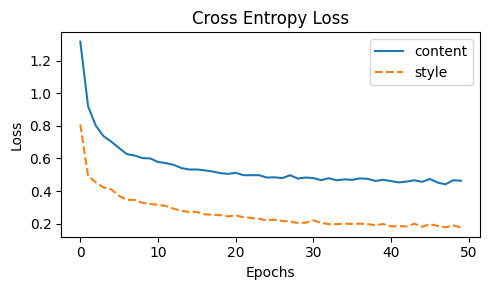

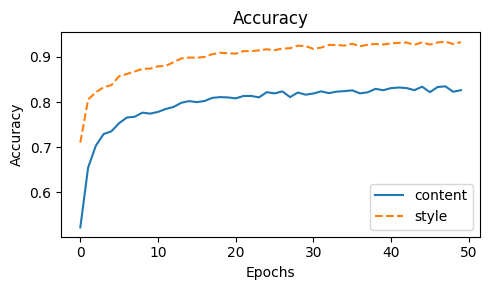

In [42]:
from matplotlib.lines import Line2D

plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_losses)), label="style", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_predict_style.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_accs)), label="style", linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_predict_style.pdf")